# Image Classification using Keras and sklearn

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns # statistical data visualization, used to plot total count for each label
import random # used to split trainig and testing data
import warnings
import os # used to iterate through all the images in the specified directory

# libraries used for loading images and visualization
from keras.preprocessing.image import load_img
warnings.filterwarnings('ignore')

# libraries to split the data into training and testing data
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator

# libraries to build the model
from keras import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout

In [2]:
# image augmentation library 
import tensorflow as tf
import tensorflow_io as tfio

Spiral_DataSet1_relabelled\healthy\V01HE02.png 0
total number of labels:  102
total number of images:  102
                                                images  label
0    Spiral_DataSet1_relabelled\parkinsons\V15PE01.png      1
1       Spiral_DataSet1_relabelled\healthy\V55HE02.png      0
2       Spiral_DataSet1_relabelled\healthy\V07HE02.png      0
3    Spiral_DataSet1_relabelled\parkinsons\V07PE02.png      1
4       Spiral_DataSet1_relabelled\healthy\V06HE01.png      0
..                                                 ...    ...
97   Spiral_DataSet1_relabelled\parkinsons\V06PE01.png      1
98   Spiral_DataSet1_relabelled\parkinsons\V14PE03.png      1
99   Spiral_DataSet1_relabelled\parkinsons\V13PE01.png      1
100     Spiral_DataSet1_relabelled\healthy\V02HE01.png      0
101  Spiral_DataSet1_relabelled\parkinsons\V09PE03.png      1

[102 rows x 2 columns]


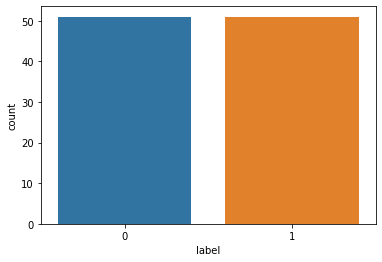

In [81]:
## --------------------------------------------------------
#                  Create the Dataframe
## --------------------------------------------------------
img_path = [] # store image paths for all images (all images are size 256x256)
label = [] # healthy (0) vs parkinsons (1)
dataset_folder = 'Spiral_DataSet1_relabelled'

# iterate through all of the images to create a binary array corresponding to the image labels
for labeled_folder in os.listdir(dataset_folder):
    for img in os.listdir(dataset_folder + "/" + labeled_folder):
        if labeled_folder == 'healthy':
            label.append(0)
        else:
            label.append(1)
        img_path.append(os.path.join(dataset_folder, labeled_folder, img))

# total number of images and labels should match
print(img_path[1], label[1])
print("total number of labels: ", len(label))
print("total number of images: ", len(img_path))

# now create the dataframe
df = pd.DataFrame()
df['images'] = img_path
df['label']  = label


df = df.sample(frac=1).reset_index(drop=True) # randomize the images, rather than having them be in order

print(df)

# show the total count for each of the labels
sns.countplot(df['label'])
plt.show()

In [191]:
## -----------------------------------------------------------
#               Split into test and training data
## -----------------------------------------------------------
#randomly split data in train and test subsets
train, test = train_test_split(df, test_size=0.2)

# convert y-col to str for binary class_mode
train['label'] = train['label'].astype('str')
test['label']  = test['label'].astype('str')

In [40]:
def convert_img_color(filename):
    #img = tf.image.rgb_to_yiq(filename)
    img = tfio.experimental.color.rgb_to_grayscale(filename)
    return img

In [192]:

# normalize the data
train_gen = ImageDataGenerator(
    rescale=1./255,
    #rotation_range=45,
    fill_mode='nearest',
    #brightness_range=[.5,.5],
    #preprocessing_function=convert_img_color

    #rotation_range = 40, # augmentation of images (helps to avoid overfitting)
    #shear_range = 0.2,
    #zoom_range = 0.2,
    #horizontal_flip = True,
)
test_gen = ImageDataGenerator(
    rescale=1./255,
    #fill_mode='nearest',
    #brightness_range=[1.5,1.5],
    #preprocessing_function=convert_img_color
    )

# take the train and test data and generate batches
train_data = train_gen.flow_from_dataframe(
    train,
    x_col='images', 
    y_col='label', 
    target_size=(128,128), 
    #color_mode='grayscale',
    batch_size= 32, 
    class_mode='binary'
)

test_data = test_gen.flow_from_dataframe(
    test,
    x_col='images', 
    y_col='label', 
    target_size=(128,128), 
    #color_mode='grayscale',
    batch_size= 32,
    class_mode='binary'
)

Found 81 validated image filenames belonging to 2 classes.
Found 21 validated image filenames belonging to 2 classes.


In [14]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        #newImg=tf.image.rgb_to_hsv(img)
        ax.imshow(img)            
        
    plt.tight_layout()
    plt.show()

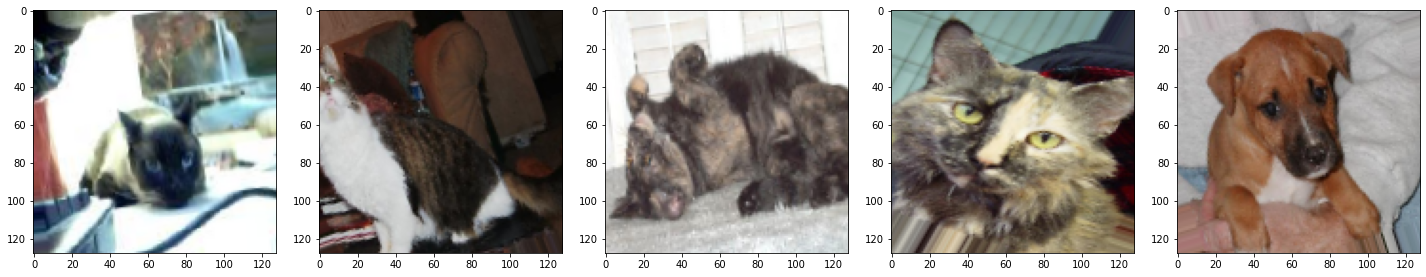

In [22]:
augmented_images = [train_data[0][0][i] for i in range(5)]
plotImages(augmented_images)

In [193]:
## -----------------------------------------------------------
#                       Build the Model
## -----------------------------------------------------------

model = Sequential([
    Conv2D(16, (3,3), activation='relu', input_shape=(128,128,3)),
    MaxPool2D((2,2)),
    Conv2D(32, (3,3), activation='relu'),
    MaxPool2D((2,2)),
    Conv2D(32, (3,3), activation='relu'),
    MaxPool2D((2,2)),
    Dropout(0.1),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1,activation='sigmoid')
])

'''
model = Sequential([
    Conv2D(16, (3,3), activation='relu', input_shape=(128,128,3)),
    MaxPool2D((2,2)),
    Dropout(0.25),
    Conv2D(32, (3,3), activation='relu'),
    MaxPool2D((2,2)),
    Dropout(0.4),
    Conv2D(64, (3,3), activation='relu'),
    MaxPool2D((2,2)),
    Dropout(0.4),
    Conv2D(64, (3,3), activation='relu'),
    MaxPool2D((2,2)),
    Dropout(0.4),
    Conv2D(64, (3,3), activation='relu'),
    MaxPool2D((2,2)),
    Dropout(0.4),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.3),
    Dense(1,activation='sigmoid')
])


model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(128,128,1)),
    MaxPool2D((2,2)),
    Dropout(0.25),
    Conv2D(64, (3,3), activation='relu'),
    MaxPool2D((2,2)),
    Dropout(0.4),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.3),
    Dense(1,activation='sigmoid')
])
'''

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

## Train the model
trained_model = model.fit(train_data, epochs=20, validation_data=test_data)

Model: "sequential_57"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_160 (Conv2D)         (None, 126, 126, 16)      448       
                                                                 
 max_pooling2d_160 (MaxPooli  (None, 63, 63, 16)       0         
 ng2D)                                                           
                                                                 
 conv2d_161 (Conv2D)         (None, 61, 61, 32)        4640      
                                                                 
 max_pooling2d_161 (MaxPooli  (None, 30, 30, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_162 (Conv2D)         (None, 28, 28, 32)        9248      
                                                                 
 max_pooling2d_162 (MaxPooli  (None, 14, 14, 32)     

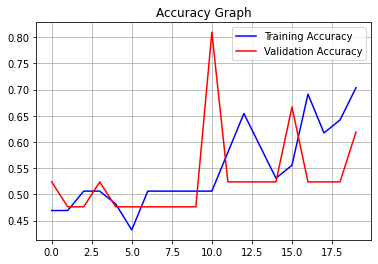

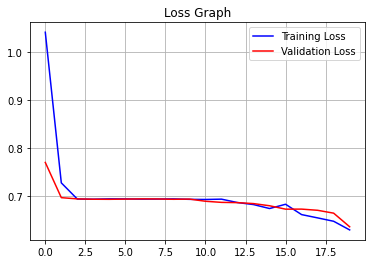

In [194]:
## -----------------------------------------------------------
#                       Plot the Results
## -----------------------------------------------------------
# Accuracy and Validation Accuracy
accuracy = trained_model.history['accuracy']
val_acc = trained_model.history['val_accuracy']
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.grid()
plt.figure()

# Loss and Validation Loss
loss = trained_model.history['loss']
val_loss = trained_model.history['val_loss']

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.grid()
plt.show()